In [1]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
train_data_dir = 'D:/Desktopshifted/MTech - PES university/Sem-3/CapstoneProject/Dataset/archive/COVID-19_Radiography_Dataset/SubData4/SubData4Output/train/'
test_data_dir = 'D:/Desktopshifted/MTech - PES university/Sem-3/CapstoneProject/Dataset/archive/COVID-19_Radiography_Dataset/SubData4/SubData4Output/test/'
val_data_dir = 'D:/Desktopshifted/MTech - PES university/Sem-3/CapstoneProject/Dataset/archive/COVID-19_Radiography_Dataset/SubData4/SubData4Output/val/'

In [6]:
input_shape = (224,224,3)
input_layer = Input(shape = (224, 224, 3))

In [7]:
img_width , img_height = [224,224]
batch_size = 16

In [9]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode = 'nearest'
        )
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_set = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True)

Found 3702 images belonging to 4 classes.


In [11]:
test_set = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
       )

Found 794 images belonging to 4 classes.


In [12]:
val_set = val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
       )

Found 796 images belonging to 4 classes.


In [13]:
train_y=train_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [14]:
train_set.class_indices

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral_Pneumonia': 3}

In [15]:
VGG16_base = VGG16(weights = 'imagenet',input_shape = input_shape,include_top = False)

In [16]:
for layer in VGG16_base.layers:
    layer.trainable =  False

In [17]:
VGG16_base.layers[15].trainable = True
VGG16_base.layers[16].trainable = True
VGG16_base.layers[17].trainable = True
VGG16_base.layers[18].trainable = True

In [18]:
VGG16_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
top_model = VGG16_base.output

In [20]:
from keras.layers import Dense, Dropout, Flatten,BatchNormalization

In [21]:
top_model = Flatten(name="flatten")(top_model)

In [22]:
top_model = BatchNormalization()(top_model)

In [23]:
top_model = Dense(256, activation='relu')(top_model)

In [24]:
top_model = Dropout(0.7)(top_model)

In [25]:
top_model = BatchNormalization()(top_model)

In [26]:
top_model = Dense(128, activation='relu')(top_model)

In [27]:
top_model = Dropout(0.7)(top_model)

In [28]:
output_layer = Dense(4, activation='softmax')(top_model)

In [29]:
from keras.models import Model

In [30]:
model = Model(inputs=VGG16_base.input, outputs=output_layer)

In [31]:
lr = 0.0001

In [32]:
optimizer = 'adam'

In [33]:
from tensorflow.keras.optimizers import Adam, Adamax

In [34]:
optm = Adam(learning_rate=0.0001)

In [35]:
model.compile(optimizer=optm, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [36]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [37]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint

In [38]:
EarlyStopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=.01,
                              patience=6,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)

In [39]:
rlr = ReduceLROnPlateau( monitor='val_accuracy',
                            factor=0.01,
                            patience=6,
                            verbose=0,
                            mode='max',
                            min_delta=0.01)

In [40]:
model_save = ModelCheckpoint('./vgg16_last4layertrainble_model_opt1.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)

In [41]:
nb_train_samples = 3702 # number of training-samples
nb_test_samples = 794 # number of test-samples
nb_validation_samples = 796 # number of validation-samples
epochs = 8  
batch_size  = 16

In [42]:
model_history = model.fit(train_set,steps_per_epoch = nb_train_samples // batch_size,epochs = epochs,validation_data = test_set,callbacks=[EarlyStopping, model_save,rlr])

Epoch 1/5
115/115 [==============================] - ETA: 0s - loss: 1.8503 - accuracy: 0.3723
Epoch 1: val_loss improved from inf to 1.12584, saving model to .\vgg16_last4layertrainble_model_opt1.h5
115/115 [==============================] - 532s 5s/step - loss: 1.8503 - accuracy: 0.3723 - val_loss: 1.1258 - val_accuracy: 0.6071 - lr: 1.0000e-04
Epoch 2/5
115/115 [==============================] - ETA: 0s - loss: 1.5635 - accuracy: 0.4705
Epoch 2: val_loss improved from 1.12584 to 0.73594, saving model to .\vgg16_last4layertrainble_model_opt1.h5
115/115 [==============================] - 562s 5s/step - loss: 1.5635 - accuracy: 0.4705 - val_loss: 0.7359 - val_accuracy: 0.7179 - lr: 1.0000e-04
Epoch 3/5
115/115 [==============================] - ETA: 0s - loss: 1.4830 - accuracy: 0.4935
Epoch 3: val_loss did not improve from 0.73594
115/115 [==============================] - 615s 5s/step - loss: 1.4830 - accuracy: 0.4935 - val_loss: 0.8097 - val_accuracy: 0.6877 - lr: 1.0000e-04
Epoch 4

In [57]:
model = model_history.model

In [58]:
model_history2 = model.fit(train_set,steps_per_epoch = nb_train_samples // batch_size,epochs = 5,validation_data = test_set,callbacks=[EarlyStopping, model_save,rlr])

Epoch 1/5
115/115 [==============================] - ETA: 0s - loss: 1.3309 - accuracy: 0.5484
Epoch 1: val_loss did not improve from 0.64696
115/115 [==============================] - 666s 6s/step - loss: 1.3309 - accuracy: 0.5484 - val_loss: 0.6564 - val_accuracy: 0.7456 - lr: 1.0000e-04
Epoch 2/5
115/115 [==============================] - ETA: 0s - loss: 1.2636 - accuracy: 0.5579
Epoch 2: val_loss did not improve from 0.64696
115/115 [==============================] - 703s 6s/step - loss: 1.2636 - accuracy: 0.5579 - val_loss: 0.8336 - val_accuracy: 0.7028 - lr: 1.0000e-04
Epoch 3/5
115/115 [==============================] - ETA: 0s - loss: 1.1823 - accuracy: 0.5880
Epoch 3: val_loss did not improve from 0.64696
115/115 [==============================] - 693s 6s/step - loss: 1.1823 - accuracy: 0.5880 - val_loss: 1.0759 - val_accuracy: 0.5302 - lr: 1.0000e-04
Epoch 4/5
 51/115 [============>.................] - ETA: 4:35 - loss: 1.0959 - accuracy: 0.6189

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

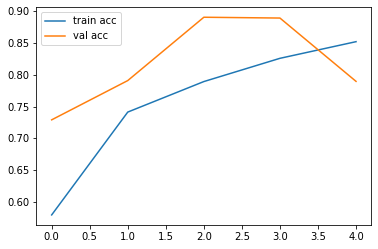

In [43]:
# accuracies
plt.plot(model_history.history['accuracy'], label='train acc')
plt.plot(model_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('Vgg16-acc-rps-2.png')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

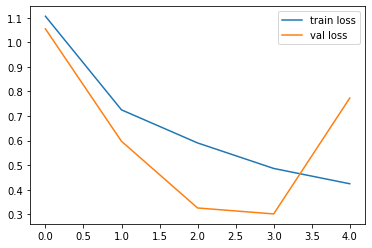

In [44]:
# loss
plt.plot(model_history.history['loss'], label='train loss')
plt.plot(model_history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('Vgg16-loss-rps-2.png')
plt.show()

In [45]:
from sklearn.metrics import classification_report,confusion_matrix

In [46]:
import tqdm
val_set.reset()
X_val, y_val = next(val_set)
for i in tqdm.tqdm(range(int(val_set.n/batch_size)-1)): 
    img, label = next(val_set)
    X_val = np.append(X_val, img, axis=0 )
    y_val = np.append(y_val, label, axis=0)
print(X_val.shape, y_val.shape)

  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  4%|███▌                                                                               | 1/23 [00:00<00:07,  2.83it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  9%|███████▏                                                                           | 2/23 [00:00<00:07,  2.99it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 13%|██████████▊                                                                        | 3/23 [00:01<00:06,  2.88it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 17%|██████████████▍                                                                    | 4/23 [00:01<00:06,  3.02it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 22%|██████████████████                                                                 | 5/23 [00:01<00:06,  2.88it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 26%|█████████████████████▋                                                             | 6/23 [00:02<00:05,  2.96it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 30%|█████████████████████████▎                                                         | 7/23 [00:02<00:05,  2.89it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 35%|████████████████████████████▊                                                      | 8/23 [00:02<00:05,  2.95it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 39%|████████████████████████████████▍                                                  | 9/23 [00:03<00:04,  2.94it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 43%|███████████████████████████████████▋                                              | 10/23 [00:03<00:04,  2.95it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 48%|███████████████████████████████████████▏                                          | 11/23 [00:03<00:04,  2.70it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 52%|██████████████████████████████████████████▊                                       | 12/23 [00:04<00:04,  2.73it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 57%|██████████████████████████████████████████████▎                                   | 13/23 [00:04<00:03,  2.73it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 61%|█████████████████████████████████████████████████▉                                | 14/23 [00:04<00:03,  2.69it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 65%|█████████████████████████████████████████████████████▍                            | 15/23 [00:05<00:03,  2.51it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 70%|█████████████████████████████████████████████████████████                         | 16/23 [00:05<00:02,  2.51it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 74%|████████████████████████████████████████████████████████████▌                     | 17/23 [00:06<00:02,  2.51it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 78%|████████████████████████████████████████████████████████████████▏                 | 18/23 [00:06<00:02,  2.49it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 83%|███████████████████████████████████████████████████████████████████▋              | 19/23 [00:07<00:01,  2.53it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 87%|███████████████████████████████████████████████████████████████████████▎          | 20/23 [00:07<00:01,  2.47it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 91%|██████████████████████████████████████████████████████████████████████████▊       | 21/23 [00:07<00:00,  2.43it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 96%|██████████████████████████████████████████████████████████████████████████████▍   | 22/23 [00:08<00:00,  2.36it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:08<00:00,  2.61it/s]

(768, 224, 224, 3) (768, 4)


In [47]:
score = model.evaluate(X_val, y_val, verbose = 0 )
print("Test Score: ", score[0])
print("Test accuracy: ", score[1])

Test Score:  0.8463762402534485
Test accuracy:  0.7721354365348816


In [48]:
#predict
y_pred=model.predict(X_val)
y_pred_classes=np.argmax(y_pred,axis=1)

24/24 [==============================] - 127s 5s/step


<IPython.core.display.Javascript object>

In [49]:
y_pred_classes = tf.keras.utils.to_categorical(y_pred_classes, num_classes=4)

<IPython.core.display.Javascript object>

In [50]:
y_pred_classes

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [51]:
#get classification report
print(classification_report(y_pred_classes,y_val))

              precision    recall  f1-score   support

           0       0.12      1.00      0.22        16
           1       0.79      0.80      0.80       213
           2       0.96      0.73      0.83       489
           3       0.98      0.96      0.97        50

   micro avg       0.77      0.77      0.77       768
   macro avg       0.71      0.87      0.70       768
weighted avg       0.90      0.77      0.82       768
 samples avg       0.77      0.77      0.77       768

